# UMAP + Stats

Basic UMAP plotting + stats such as % number of cells per day, cluster + composition of cluster/day.

**Inputs**: 
1. `metadata.tsv` with UMAP/densMAP coordinates, day and cluster.
2. Config:
    - Colours for each day
    - For each cluster, colour, description, new cluster number (set to same as original if it should not be changed)

In [1]:
library(ggplot2)
library(Matrix)
library(patchwork)

In [2]:
DAYS = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14")

## Loading Inputs

### MetaData

In [3]:
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../../analysis/20200206_pmat_snapATAC/sessions/20200520_n68916/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
metaData$sample = factor(metaData$sample, levels=DAYS)
dim(metaData)
head(metaData, 5)

[1] 68916     5

barcode          sample umap1    umap2    
D0_AAACAACGACGATTAC AAACAACGACGATTAC D0     6.565758 -8.649868
D0_AAACAACGAGCGCACT AAACAACGAGCGCACT D0     5.604522 -7.835411
D0_AAACACGCTACGCCAC AAACACGCTACGCCAC D0     5.130516 -7.593246
D0_AAACACGCTAGTACGG AAACACGCTAGTACGG D0     4.926843 -8.365463
D0_AAACACGCTCCTCAAA AAACACGCTCCTCAAA D0     6.056337 -5.647577
                    cells              
D0_AAACAACGACGATTAC D0_AAACAACGACGATTAC
D0_AAACAACGAGCGCACT D0_AAACAACGAGCGCACT
D0_AAACACGCTACGCCAC D0_AAACACGCTACGCCAC
D0_AAACACGCTAGTACGG D0_AAACACGCTAGTACGG
D0_AAACACGCTCCTCAAA D0_AAACACGCTCCTCAAA

In [4]:
# this is a kludge for now, clusters should also be present in same metaData as above
snapATAC_metaData = read.table("../../analysis/20200122_snapATAC/snapATAC_sessions/20200518_n76052/metadata.tsv", header = T)
rownames(snapATAC_metaData) = paste(snapATAC_metaData$sample, snapATAC_metaData$barcode, sep='_')

metaData$cluster = snapATAC_metaData[rownames(metaData), "cluster"] 
head(metaData)

barcode          sample umap1    umap2    
D0_AAACAACGACGATTAC AAACAACGACGATTAC D0     6.565758 -8.649868
D0_AAACAACGAGCGCACT AAACAACGAGCGCACT D0     5.604522 -7.835411
D0_AAACACGCTACGCCAC AAACACGCTACGCCAC D0     5.130516 -7.593246
D0_AAACACGCTAGTACGG AAACACGCTAGTACGG D0     4.926843 -8.365463
D0_AAACACGCTCCTCAAA AAACACGCTCCTCAAA D0     6.056337 -5.647577
D0_AAACACGCTCGAGTGA AAACACGCTCGAGTGA D0     3.408866 -9.058377
                    cells               cluster
D0_AAACAACGACGATTAC D0_AAACAACGACGATTAC 5      
D0_AAACAACGAGCGCACT D0_AAACAACGAGCGCACT 5      
D0_AAACACGCTACGCCAC D0_AAACACGCTACGCCAC 5      
D0_AAACACGCTAGTACGG D0_AAACACGCTAGTACGG 6      
D0_AAACACGCTCCTCAAA D0_AAACACGCTCCTCAAA 5      
D0_AAACACGCTCGAGTGA D0_AAACACGCTCGAGTGA 6

In [5]:
# another kludge, exluding a cluster which corresponds to iPSCs
metaData = metaData[metaData$cluster!=18, ]

### Day and Cluster Configs

In [6]:
day_config = read.table("../configs/day.tsv", comment.char = '', header=T)
day_config$colour = as.character(day_config$colour)
day_config$day = factor(day_config$day, levels=DAYS)
rownames(day_config) = day_config$day
day_config

day colour 
D0  D0  #336699
D2  D2  #0AABB7
D4  D4  #D6E82F
D6  D6  #B14AED
D8  D8  #2D3142
D10 D10 #FC7753
D12 D12 #FF70A6
D14 D14 #A61C24

In [7]:
cluster_config = read.table("../configs/cluster.tsv", comment.char = '', header=T, sep='\t')
cluster_config$colour = as.character(cluster_config$colour)
cluster_config$description = as.character(cluster_config$description)

# kludge since manually removed some clusters from metaData
cluster_config = cluster_config[rownames(cluster_config) %in% metaData$cluster, ]

rownames(cluster_config) = cluster_config$cluster
cluster_config

cluster colour  description            new_cluster
1   1      #CCCCCC Intermediate           12         
2   2      #E41A1C Pre-iPSC               15         
3   3      #377EB8 Fibroblast-like         5         
4   4      #4DAF4A Fibroblast-like         3         
5   5      #984EA3 Fibroblast              1         
6   6      #FF7F00 Fibroblast              2         
7   7      #4B644A Fibroblast-like         4         
8   8      #A65628 Doublets               17         
9   9      #F781BF Keratinocyte-like       6         
10 10      #999999 Pre-iPSC               16         
11 11      #66C2A5 Partially-reprogrammed 14         
12 12      #FC8D62 Intermediate           11         
13 13      #8DA0CB Intermediate           10         
14 14      #BCF4F5 Early intermediate      7         
15 15      #A6D854 Intermediate           13         
16 16      #FFD92F Neural-like             9         
17 17      #E5C494 Neural-like             8

## Plotting

In [8]:
plot_df = data.frame(metaData)
# shuffle so days don't overlap
plot_df = plot_df[sample(dim(plot_df)[1]), ]
plot_df$sample = factor(plot_df$sample, levels=DAYS)

In [9]:
# replace cluster with new cluster
all(rownames(cluster_config) == seq(1,nrow(cluster_config))) # check initial rows are in order
plot_df$cluster = cluster_config$new_cluster[plot_df$cluster]

[1] TRUE

In [10]:
head(plot_df)

barcode          sample umap1      umap2     
D14_TCTAACGGAACTAGGG TCTAACGGAACTAGGG D14     1.9324244  7.4533014
D4_ACGGTTAACTTGTACG  ACGGTTAACTTGTACG D4     -3.5331730  2.8396681
D6_TCTACTAACCCAAGTT  TCTACTAACCCAAGTT D6     -5.3043002  2.6235489
D8_GATAGCGGACAGTCCG  GATAGCGGACAGTCCG D8      0.1926358 -4.0113145
D6_CAGCTGTCTCCTGCGA  CAGCTGTCTCCTGCGA D6     -5.4205749  0.9932127
D10_CTGGTGGTGAGGTGAC CTGGTGGTGAGGTGAC D10    -2.5862034  1.5730591
                     cells                cluster
D14_TCTAACGGAACTAGGG D14_TCTAACGGAACTAGGG 15     
D4_ACGGTTAACTTGTACG  D4_ACGGTTAACTTGTACG  12     
D6_TCTACTAACCCAAGTT  D6_TCTACTAACCCAAGTT  12     
D8_GATAGCGGACAGTCCG  D8_GATAGCGGACAGTCCG   4     
D6_CAGCTGTCTCCTGCGA  D6_CAGCTGTCTCCTGCGA  11     
D10_CTGGTGGTGAGGTGAC D10_CTGGTGGTGAGGTGAC 13

### Day-wise Plot

In [11]:
daywise_umap <- ggplot(plot_df) +
    geom_point(size=0.6, alpha=1, aes(x=umap1 , y=umap2, col=sample)) +
    scale_color_manual(values=day_config$colour) +
    # ggtitle("All Cells (Day)") + 
    theme_classic() +
    xlab("UMAP 1") + ylab("UMAP 2") +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=12),
          axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks=element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5),
          legend.position = "none") +
    coord_fixed()

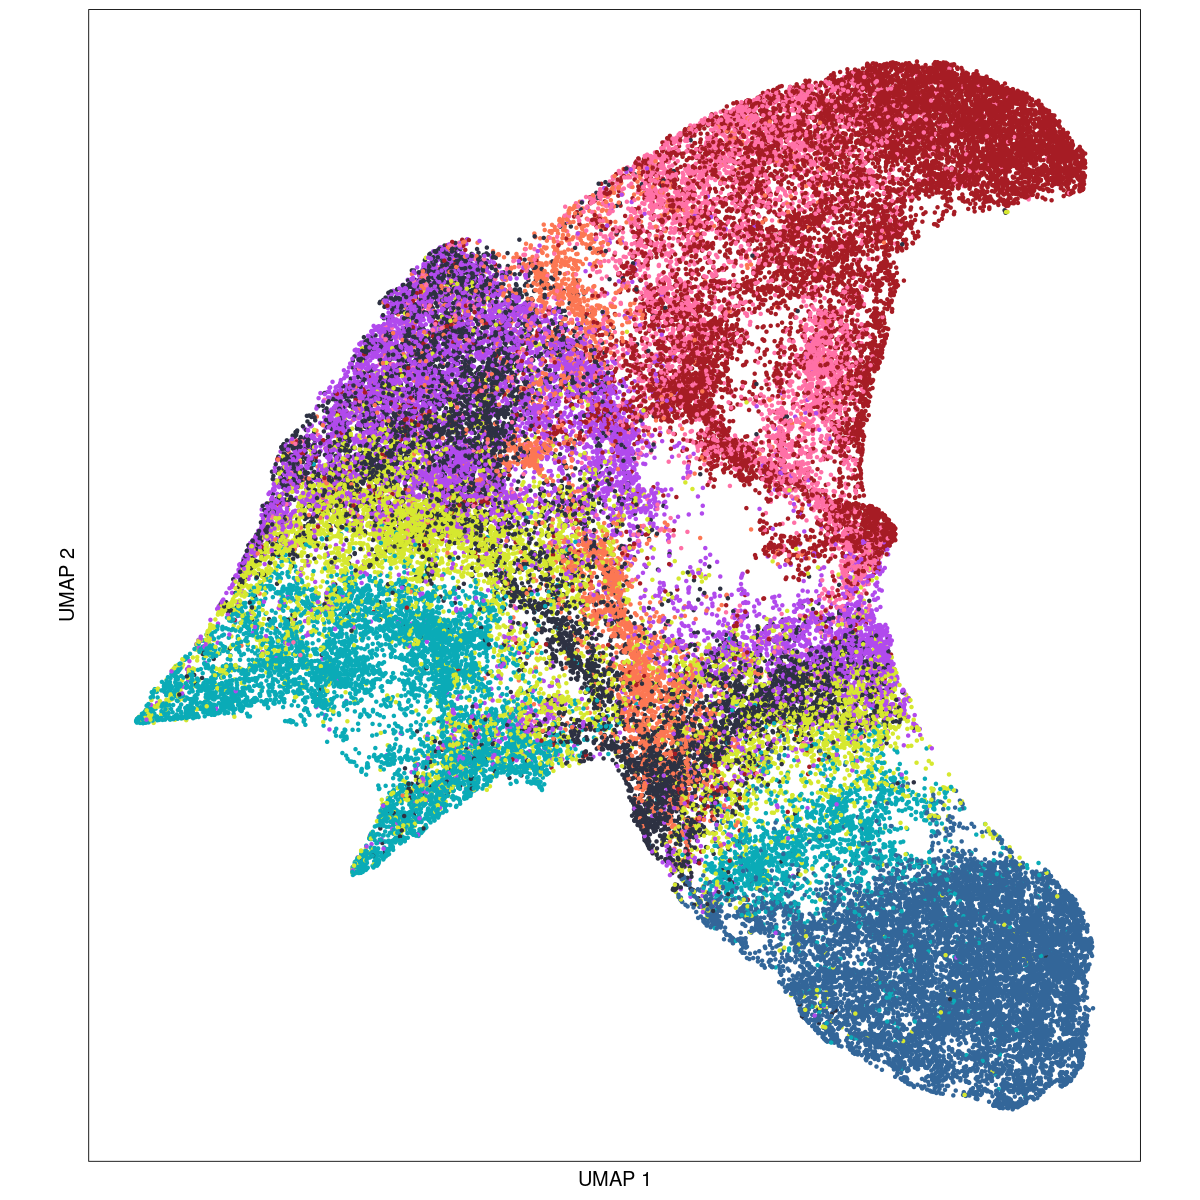

In [12]:
options(repr.plot.width = 10, repr.plot.height = 10)
daywise_umap

In [37]:
saveRDS(daywise_umap, file=sprintf("subfigs/%s_daywise_umap.rds",
                                   format(Sys.Date(), "%Y%m%d")))

In [13]:
daywise_counts_df = data.frame(table(metaData$sample))
colnames(daywise_counts_df) = c("day", "freq")
daywise_counts_df$colour = day_config$colour
# reverse for order after flipping
daywise_counts_df$day = factor(daywise_counts_df$day, levels=rev(DAYS))
daywise_counts_df

day freq  colour 
1 D0  10405 #336699
2 D2   8259 #0AABB7
3 D4   7987 #D6E82F
4 D6   9698 #B14AED
5 D8   9125 #2D3142
6 D10  3598 #FC7753
7 D12  5952 #FF70A6
8 D14 13886 #A61C24

In [14]:
daywise_counts <- ggplot(daywise_counts_df, aes(x = day, y = freq))+
    geom_col(aes(fill = day), width = 1, color="black") +
    scale_fill_manual(values=rev(day_config$colour)) +
    coord_flip() +
    scale_y_continuous(expand = c(0, 100), limits=c(0,15000)) +
    theme_classic() +
    scale_x_discrete(position = "top") +
    ylab("Number of\nCells") +
    theme(plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.line=element_blank(),
        axis.title.y= element_blank(),
#         axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        panel.grid.major=element_line(),
        axis.text.x = element_text(angle = 90, hjust = 1),
        axis.title.x = element_text(size=13),
        legend.position = "none",
        panel.border = element_rect(colour = "black", fill=NA, size=0.5))

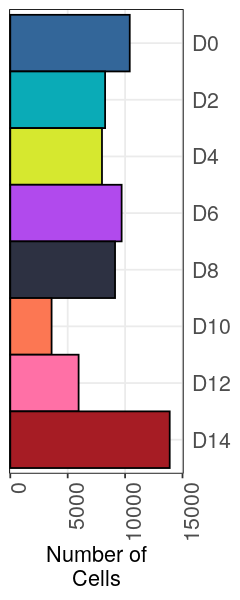

In [15]:
options(repr.plot.width = 2, repr.plot.height = 5)
daywise_counts

In [45]:
saveRDS(daywise_counts, file=sprintf("subfigs/%s_daywise_cell_count.rds",
                                   format(Sys.Date(), "%Y%m%d")))

### Cluster-wise Plot

In [16]:
clusterwise_umap <- ggplot(plot_df) +
    geom_point(size=0.6, alpha=1, aes(x=umap1 , y=umap2, col=factor(cluster))) +
    scale_color_manual(values=as.character(cluster_config$colour[order(cluster_config$new_cluster)])) +
    # cluster labels
    geom_text(data=data.frame(aggregate(plot_df[,c("umap1","umap2")], 
                                    list(plot_df$cluster), median)),
         aes(x=umap1, y=umap2, label=Group.1), fontface = "bold", size=7) +

    theme_classic() +
    xlab("UMAP 1") + ylab("UMAP 2") +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=12),
          axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks=element_blank(),
          legend.title=element_text(size=10), 
          legend.text=element_text(size=10),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5),
          legend.position = "none") +
#     guides(colour = guide_legend(title="Day",
#                                  override.aes = list(shape=16, alpha=1, size=4))) +
    coord_fixed()

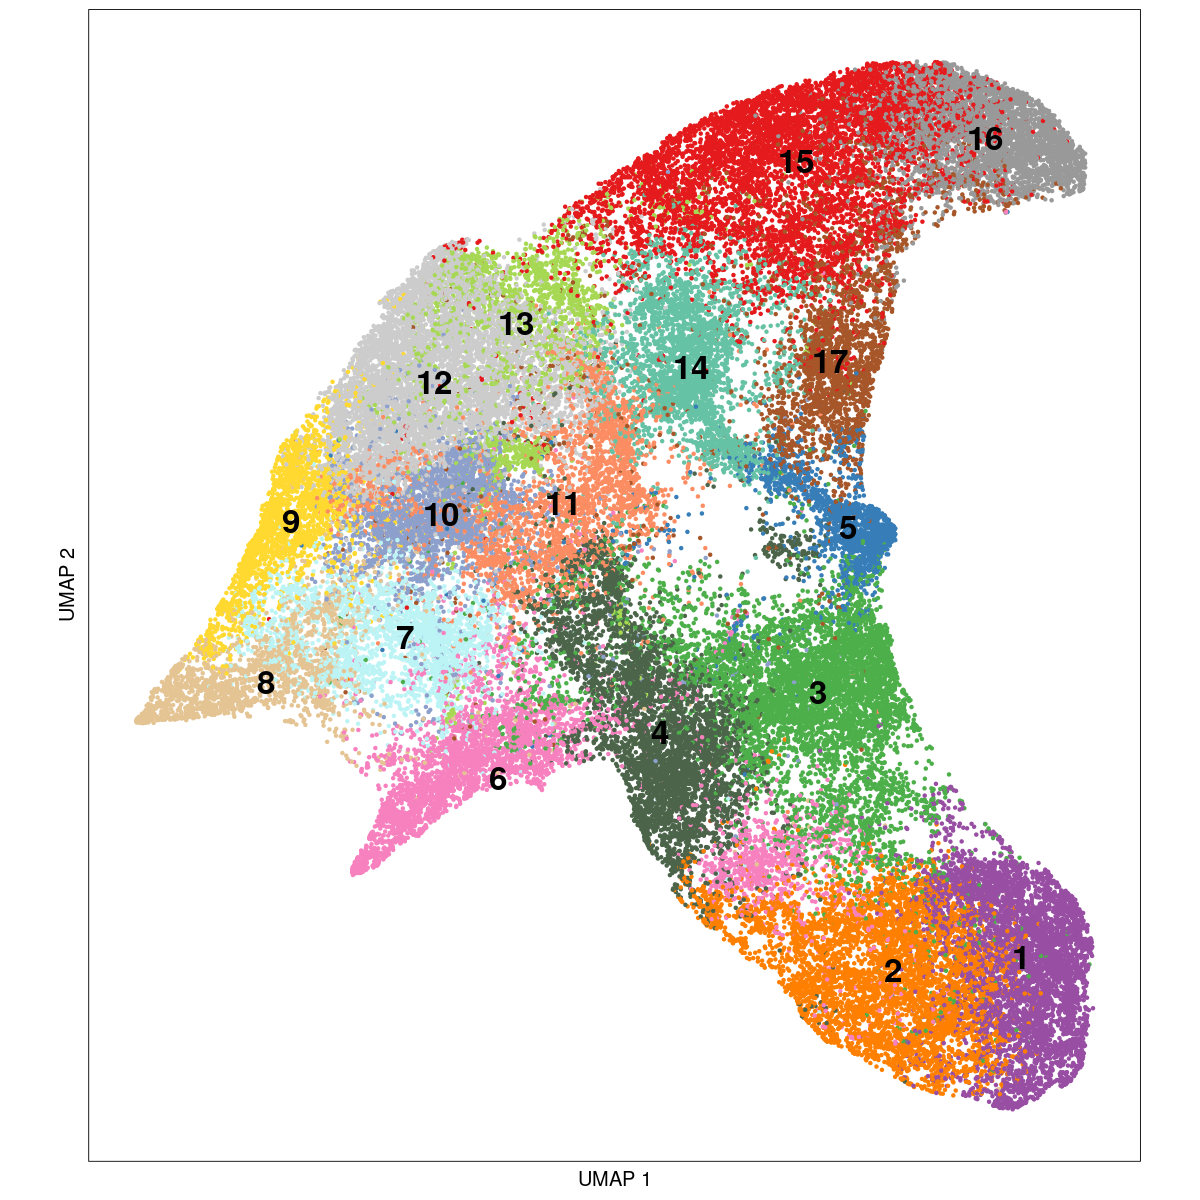

In [17]:
options(repr.plot.width = 10, repr.plot.height = 10)
clusterwise_umap

In [44]:
saveRDS(clusterwise_umap, file=sprintf("subfigs/%s_clusterwise_umap.rds",
                                   format(Sys.Date(), "%Y%m%d")))

In [18]:
clusterwise_counts_df = data.frame(table(plot_df$cluster))
colnames(clusterwise_counts_df) = c("cluster", "freq")
clusterwise_counts_df$colour = cluster_config$colour[order(cluster_config$new_cluster)]

# add description
cluster_with_description = paste(seq(1,nrow(clusterwise_counts_df)), 
                                 cluster_config$description[order(cluster_config$new_cluster)],
                                sep=' - ')
clusterwise_counts_df$cluster = factor(cluster_with_description, levels=cluster_with_description)

# reverse for order after flipping
clusterwise_counts_df$cluster = factor(clusterwise_counts_df$cluster, levels=rev(clusterwise_counts_df$cluster))

clusterwise_counts_df

cluster                     freq colour 
1  1 - Fibroblast              5257 #984EA3
2  2 - Fibroblast              5211 #FF7F00
3  3 - Fibroblast-like         6605 #4DAF4A
4  4 - Fibroblast-like         5120 #4B644A
5  5 - Fibroblast-like         1944 #377EB8
6  6 - Keratinocyte-like       4336 #F781BF
7  7 - Early intermediate      2693 #BCF4F5
8  8 - Neural-like             2179 #E5C494
9  9 - Neural-like             2344 #FFD92F
10 10 - Intermediate           2946 #8DA0CB
11 11 - Intermediate           3221 #FC8D62
12 12 - Intermediate           7376 #CCCCCC
13 13 - Intermediate           2283 #A6D854
14 14 - Partially-reprogrammed 3338 #66C2A5
15 15 - Pre-iPSC               7089 #E41A1C
16 16 - Pre-iPSC               4080 #999999
17 17 - Doublets               2888 #A65628

In [19]:
clusterwise_counts <- ggplot(clusterwise_counts_df, aes(x = cluster, y = freq))+
    geom_col(aes(fill = cluster), width = 1, color="black") +
    scale_fill_manual(values=rev(clusterwise_counts_df$colour)) +
    coord_flip() +
    scale_y_continuous(expand = c(0, 100), limits=c(0,8000)) +
    theme_classic() +
    scale_x_discrete(position = "top") +
    ylab("Number of\nCells") +
    theme(plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.line=element_blank(),
        axis.title.y= element_blank(),
#         axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        panel.grid.major=element_line(),
        axis.text.x = element_text(angle = 90, hjust = 1),
        axis.title.x = element_text(size=13),
        legend.position = "none",
        panel.border = element_rect(colour = "black", fill=NA, size=0.5))

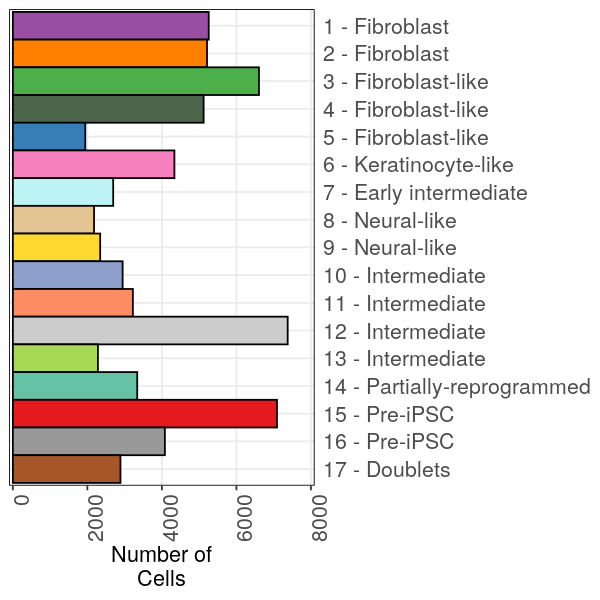

In [20]:
options(repr.plot.width = 5, repr.plot.height = 5)
clusterwise_counts

In [43]:
saveRDS(clusterwise_counts, file=sprintf("subfigs/%s_clusterwise_cell_count.rds",
                                   format(Sys.Date(), "%Y%m%d")))

### Combined 

In [21]:
daywise_counts_with_spacer = wrap_plots(plot_spacer() , daywise_counts , plot_spacer(), ncol=1, heights=c(1,1,1))

In [22]:
clusterwise_counts_with_spacer = wrap_plots(plot_spacer() , clusterwise_counts , plot_spacer(), ncol=1, heights=c(1,3,1))

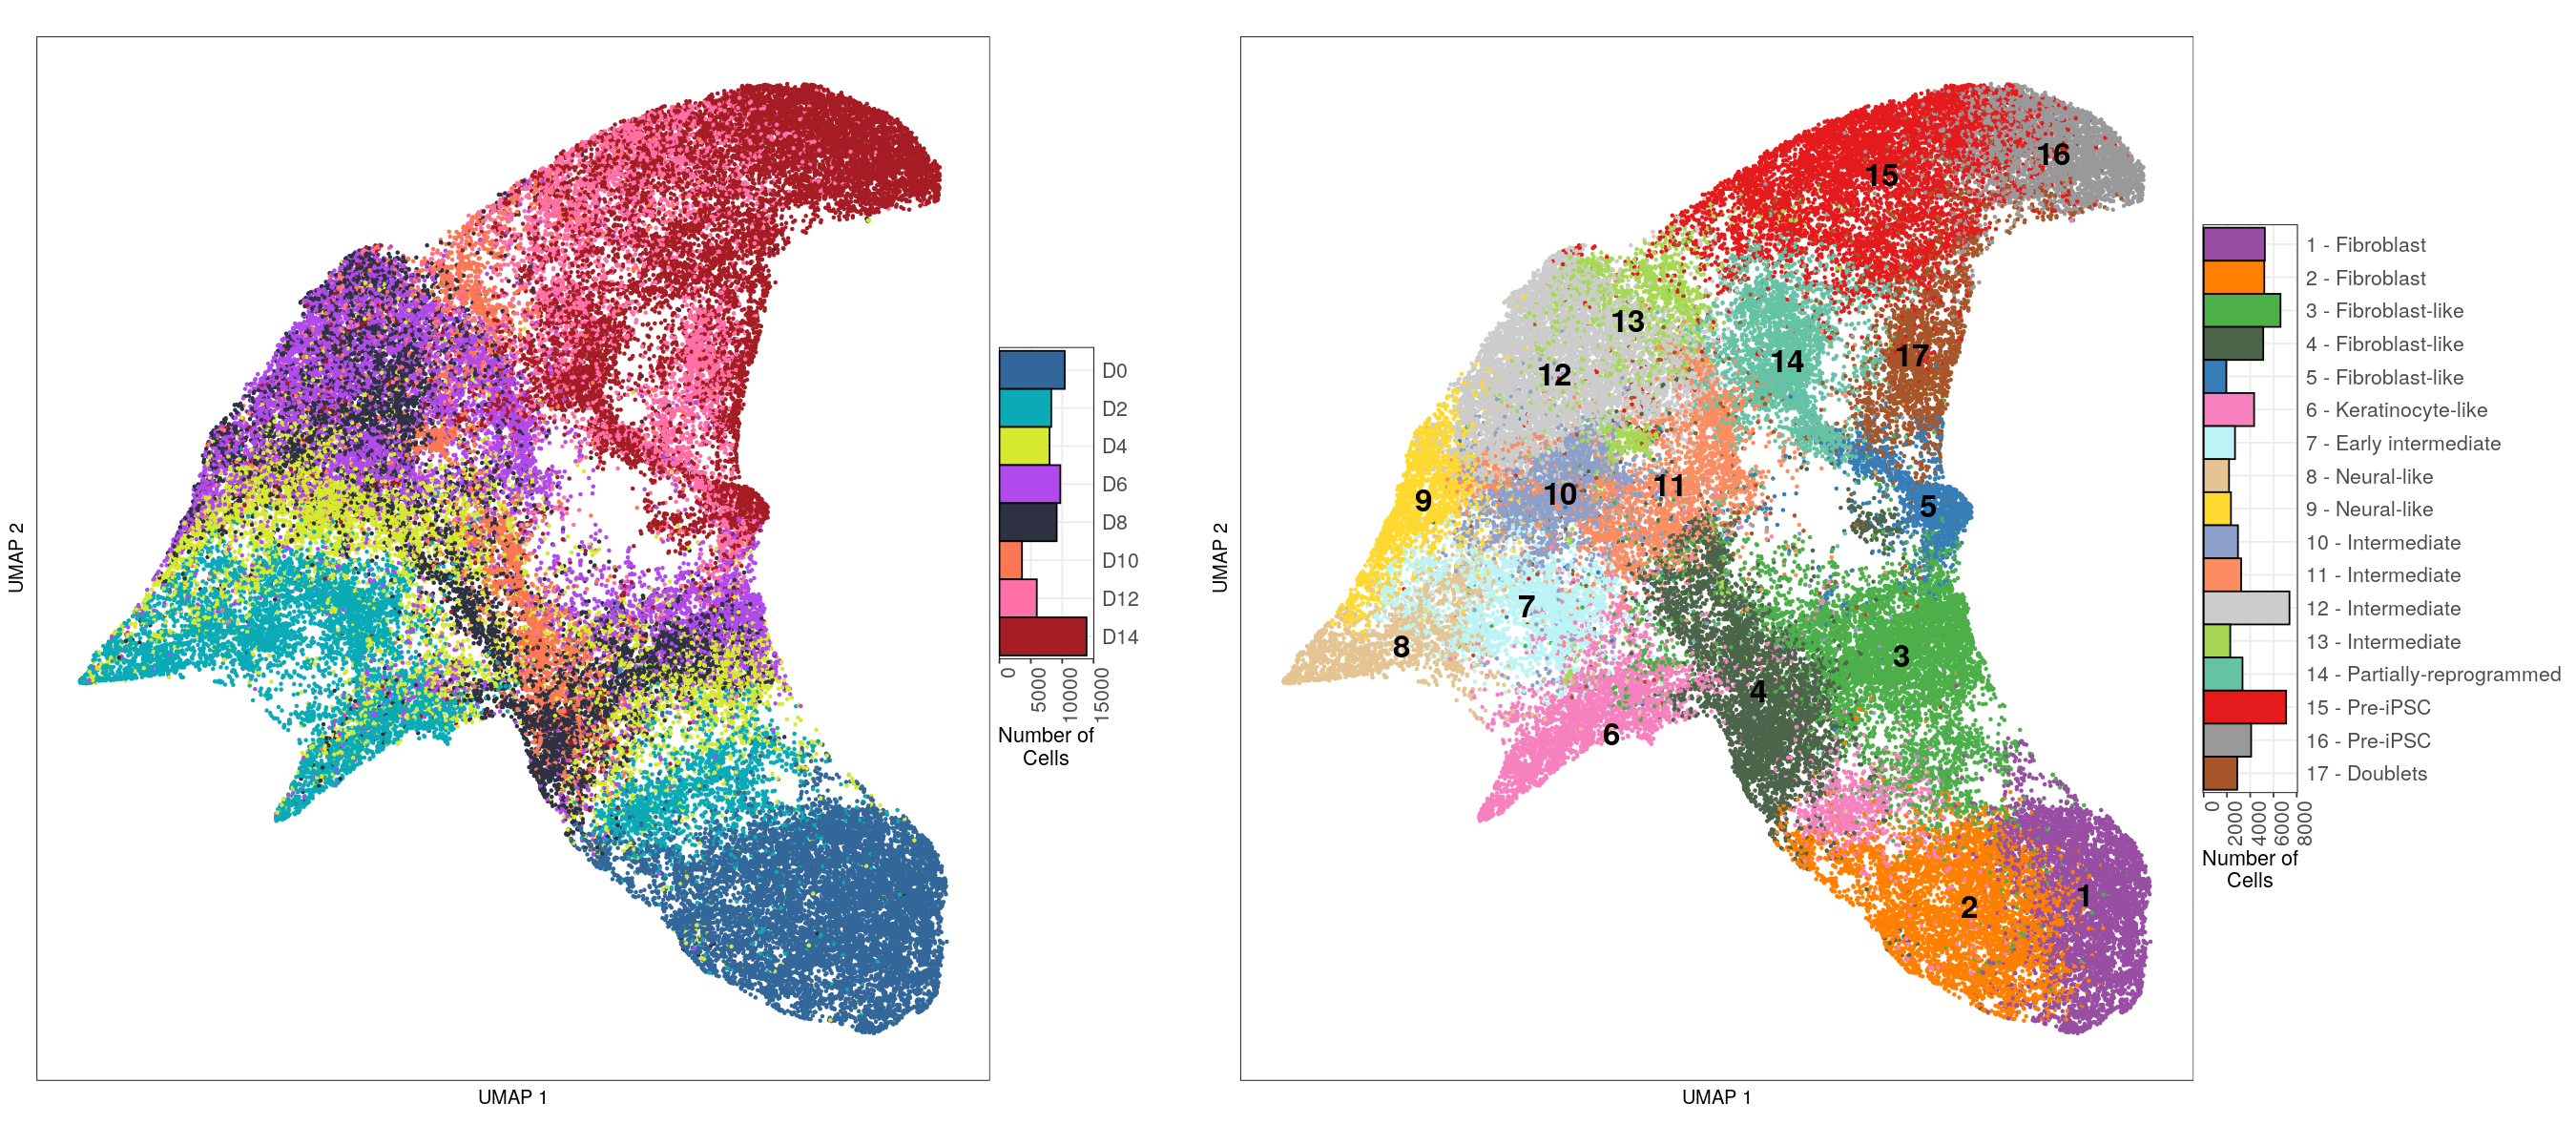

In [23]:
options(repr.plot.width = 22.5, repr.plot.height = 10)
combined_plot = wrap_plots(daywise_umap + theme(plot.margin = unit(c(0,0,0,0), "pt")), 
           daywise_counts_with_spacer, 
           plot_spacer(),
           clusterwise_umap + theme(plot.margin = unit(c(0,0,0,0), "pt")), 
           clusterwise_counts_with_spacer,
           widths=c(10,1,0.5,10,1))
combined_plot

In [24]:
# save plots individually
# ggsave("tmp.png", combined_plot, width = 22.5, height = 10)

## Day-wise and Cluster-wise Composition

### Day by Cluster

In [25]:
sample_cluster_df = data.frame(sample=plot_df$sample, cluster=plot_df$cluster, count=1)

# count cells per sample x cluster
sample_cluster_cts = aggregate(.~sample+cluster, 
                               sample_cluster_df, 
                               sum)
# normalise per sample
sample_cts = aggregate(sample_cluster_df[,"count"], list(sample_cluster_df[,"sample"]), sum)
rownames(sample_cts) = sample_cts$Group.1
sample_cts$Group.1 = NULL

# frac of cluster per sample
sample_cluster_cts$frac_cluster = 100*sample_cluster_cts$count/sample_cts[sample_cluster_cts$sample, "x"]

In [26]:
head(sample_cluster_cts)

sample cluster count frac_cluster
1 D0     1       5102  49.0341182  
2 D2     1        122   1.4771764  
3 D4     1         32   0.4006511  
4 D6     1          1   0.0103114  
5 D0     2       5008  48.1307064  
6 D2     2        131   1.5861484

In [27]:
# Stacked barplot with multiple groups
day_by_cluster_plot <- ggplot(data=sample_cluster_cts, aes(x=factor(sample, 
                                             levels=DAYS), 
                                    y=frac_cluster, 
                                    fill=as.factor(cluster))) +
    scale_fill_manual(values = cluster_config$colour[order(cluster_config$new_cluster)]) +
    geom_bar(stat="identity") +
    ylab("Percent Cells") +
    xlab("Day") +
#     guides(fill = guide_legend(ncol=2, title="Cluster", pos="center")) +
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.line=element_blank(),
#         axis.title.y= element_blank(),
#         axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
          axis.ticks.x=element_blank(),
#         panel.grid.major=element_line(),
#         axis.text.x = element_text(angle = 90, hjust = 1),
          axis.text.x = element_blank(),
        axis.title.x = element_blank(),
        legend.position = "none",
        panel.border = element_rect(colour = "black", fill=NA, size=0.5))
#     theme(legend.title.align=0.4,

In [28]:
day_colourbar <- ggplot(day_config, aes(x=day, y=1, fill = day, label=day)) +
  geom_bar(stat="identity") +
  theme_void() +
    xlab("Day") +
  scale_fill_manual(values = day_config$colour) +
  theme(legend.position = 'none',
        axis.text.x = element_text(size=14),
       axis.title.x = element_text(size=16))

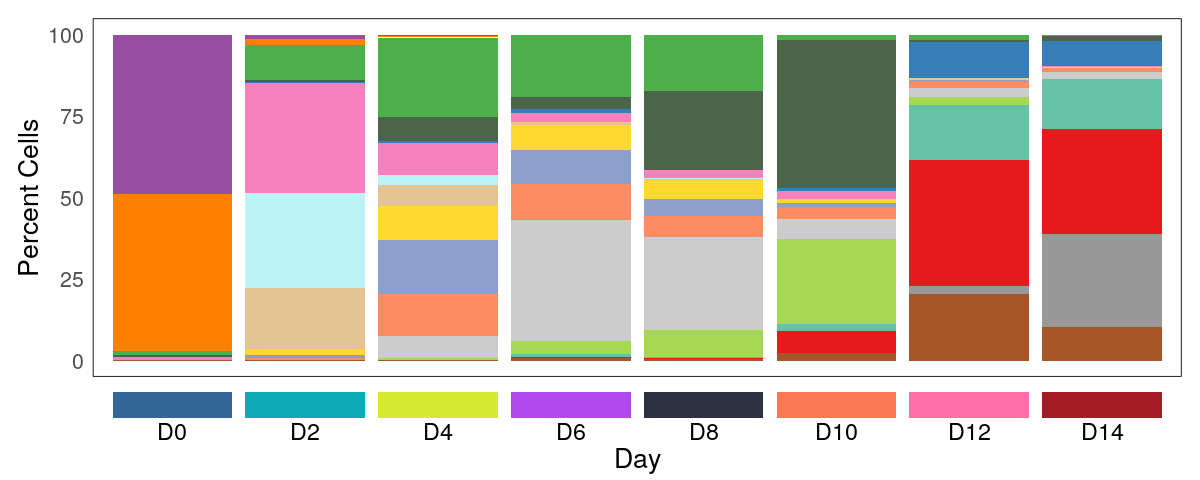

In [29]:
options(repr.plot.width = 10, repr.plot.height = 4)

day_by_cluster_with_colourbar = wrap_plots(day_by_cluster_plot, day_colourbar, nrow=2, heights=c(10,0.8))
day_by_cluster_with_colourbar

In [41]:
saveRDS(day_by_cluster_with_colourbar, file=sprintf("subfigs/%s_day_by_cluster_breakdown.rds",
                                   format(Sys.Date(), "%Y%m%d")))

### Cluster by Day

In [30]:
# normalise per cluster
cluster_norm_cts = aggregate(sample_cluster_cts[,"frac_cluster"], list(sample_cluster_cts[,"cluster"]), sum)
rownames(cluster_norm_cts) = cluster_norm_cts$Group.1
cluster_norm_cts$Group.1 = NULL

# frac of day (after normalizing for number of cells per day) per sample
sample_cluster_cts$frac_day = 100*sample_cluster_cts$frac_cluster/cluster_norm_cts[sample_cluster_cts$cluster, "x"]

In [31]:
head(sample_cluster_cts)

sample cluster count frac_cluster frac_day   
1 D0     1       5102  49.0341182   96.29211472
2 D2     1        122   1.4771764    2.90084631
3 D4     1         32   0.4006511    0.78678967
4 D6     1          1   0.0103114    0.02024931
5 D0     2       5008  48.1307064   95.18731307
6 D2     2        131   1.5861484    3.13689991

In [32]:
# Stacked barplot with multiple groups
cluster_by_day_plot <- ggplot(data=sample_cluster_cts, aes(x=as.factor(cluster), y=frac_day, fill=sample)) +
    scale_fill_manual(values = day_config$colour) +
    geom_bar(stat="identity") +
    ylab("Percent Cells") +
    xlab("Cluster") +
#     guides(fill = guide_legend(ncol=1, title="Sample", pos="center")) +
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.line=element_blank(),
    #         axis.title.y= element_blank(),
    #         axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        axis.ticks.x=element_blank(),
    #         panel.grid.major=element_line(),
        axis.text.x = element_blank(),
        axis.title.x = element_blank(),
        legend.position = "none",
        panel.border = element_rect(colour = "black", fill=NA, size=0.5))

In [33]:
cluster_colourbar <- ggplot(cluster_config, aes(x=as.factor(cluster), 
                                                y=1, 
                                                fill = as.factor(cluster), 
                                                label=as.factor(cluster))) +
  geom_bar(stat="identity") +
  xlab("Cluster") +
  theme_void() +
  scale_fill_manual(values = cluster_config$colour[order(cluster_config$new_cluster)]) +
  theme(legend.position = 'none',
        axis.text.x = element_text(size=14),
        axis.title.x = element_text(size=16))

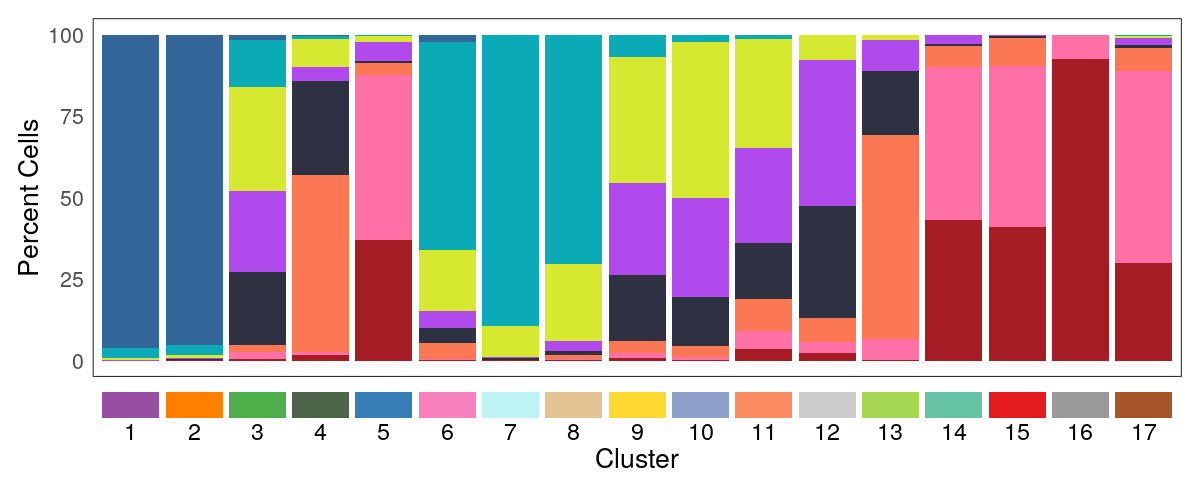

In [34]:
options(repr.plot.width = 10, repr.plot.height = 4)

cluster_by_day_with_colourbar = wrap_plots(cluster_by_day_plot, cluster_colourbar, nrow=2, heights=c(10,0.8))
cluster_by_day_with_colourbar

In [42]:
saveRDS(cluster_by_day_with_colourbar, file=sprintf("subfigs/%s_cluster_by_day_breakdown.rds",
                                   format(Sys.Date(), "%Y%m%d")))

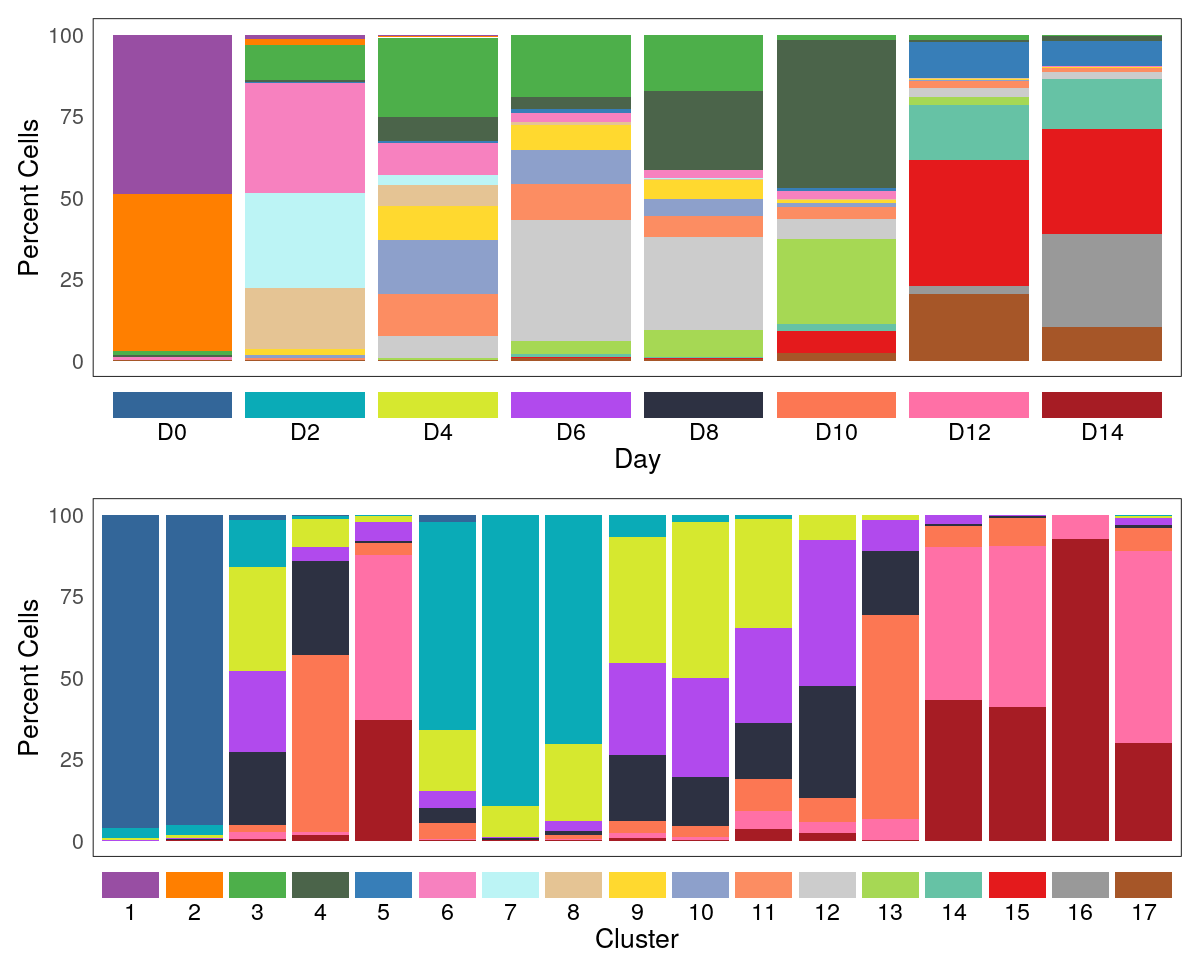

In [35]:
options(repr.plot.width = 10, repr.plot.height = 8)

composition_plot = wrap_plots(day_by_cluster_with_colourbar, 
           plot_spacer(), # otherwise "Day overlaps with plot below" 
           cluster_by_day_with_colourbar,
           ncol=1,
           heights=c(5,0,5))
composition_plot

In [279]:
ggsave("tmp.png", composition_plot, width = 10, height = 8)